In [1]:
import pandas as pd # deal with data and one-hot encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt #graph
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler,scale # scale and center the data
from sklearn.svm import SVC # model
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

In [14]:
df = pd.read_csv("weatherAUS.csv",header=0)
df = df.dropna().reset_index(drop=True)

In [15]:
print(df.shape)
df.columns

(56420, 23)


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [16]:
df.drop(['Date','Location'],axis=1, inplace=True)

cat_cols = ['WindDir9am', 'WindDir3pm', 'WindGustDir']
for col in cat_cols:
    df.loc[(df[col] == 'SSW')|(df[col] == 'SSE'), col] = 'S'
    df.loc[(df[col] == 'NNE')|(df[col] == 'NNW'), col] = 'N'
    df.loc[(df[col] == 'WSW')|(df[col] == 'WNW'), col] = 'W'
    df.loc[(df[col] == 'ENE')|(df[col] == 'ESE'), col] = 'E'
    
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,S,48.0,E,SW,6.0,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
1,18.4,28.9,0.0,14.8,13.0,S,37.0,S,S,19.0,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
2,19.4,37.6,0.0,10.8,10.6,N,46.0,N,N,30.0,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
3,21.9,38.4,0.0,11.4,12.2,W,31.0,W,W,6.0,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
4,24.2,41.0,0.0,11.2,8.4,W,35.0,NW,W,17.0,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        56420 non-null  float64
 1   MaxTemp        56420 non-null  float64
 2   Rainfall       56420 non-null  float64
 3   Evaporation    56420 non-null  float64
 4   Sunshine       56420 non-null  float64
 5   WindGustDir    56420 non-null  object 
 6   WindGustSpeed  56420 non-null  float64
 7   WindDir9am     56420 non-null  object 
 8   WindDir3pm     56420 non-null  object 
 9   WindSpeed9am   56420 non-null  float64
 10  WindSpeed3pm   56420 non-null  float64
 11  Humidity9am    56420 non-null  float64
 12  Humidity3pm    56420 non-null  float64
 13  Pressure9am    56420 non-null  float64
 14  Pressure3pm    56420 non-null  float64
 15  Cloud9am       56420 non-null  float64
 16  Cloud3pm       56420 non-null  float64
 17  Temp9am        56420 non-null  float64
 18  Temp3p

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Check the labels
label_encoder.fit(df['RainTomorrow'])
label_encoder.classes_ 

# transform
df['RainTomorrow'] = label_encoder.transform(df.RainTomorrow)

In [20]:
## Downsample the data (Because of gridsearchCV)

In [23]:
df_no = df[df.RainTomorrow == 0]
df_yes = df[df.RainTomorrow == 1]

In [24]:
## NOTE: we have 1000 for both because he wants to have more balanced outcomes so the model 
## would not only detect non_default.

df_no_sample = resample(df_no, replace=False, n_samples=1000,random_state=42)
len(df_no_sample)

1000

In [25]:
df_yes_sample = resample(df_yes, replace=False, n_samples=1000,random_state=42)
len(df_yes_sample)

1000

In [26]:
## Concate together
df_sample = pd.concat([df_no_sample, df_yes_sample])
len(df_sample)

2000

In [27]:
X = df_sample.drop('RainTomorrow', axis = 1).copy()
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
29970,8.1,22.3,0.0,3.8,10.6,E,17.0,SW,E,7.0,9.0,46.0,42.0,1023.0,1019.2,0.0,1.0,15.2,21.5,No
41863,20.7,37.6,0.0,15.6,13.5,SW,50.0,N,W,13.0,31.0,18.0,7.0,1012.1,1009.2,0.0,1.0,30.7,36.8,No
18879,11.8,21.7,0.2,3.8,12.0,S,44.0,S,S,13.0,26.0,68.0,42.0,1014.8,1012.8,7.0,1.0,15.0,21.2,No
47968,14.5,28.2,0.0,9.6,13.9,S,30.0,S,SW,11.0,19.0,58.0,46.0,1011.4,1009.4,0.0,0.0,23.6,25.2,No
40990,14.3,19.9,2.3,10.5,0.1,E,48.0,E,E,13.0,20.0,70.0,70.0,1007.6,1006.4,7.0,8.0,17.8,18.9,Yes


In [28]:
y = df_sample['RainTomorrow'].copy()
y.head()

29970    0
41863    0
18879    0
47968    0
40990    0
Name: RainTomorrow, dtype: int64

In [29]:
X_encoded = pd.get_dummies(X, columns = ['WindDir9am', 'WindDir3pm', 'WindGustDir', 'RainToday'])

X_encoded.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_E,WindGustDir_N,WindGustDir_NE,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SW,WindGustDir_W,RainToday_No,RainToday_Yes
29970,8.1,22.3,0.0,3.8,10.6,17.0,7.0,9.0,46.0,42.0,...,1,0,0,0,0,0,0,0,1,0
41863,20.7,37.6,0.0,15.6,13.5,50.0,13.0,31.0,18.0,7.0,...,0,0,0,0,0,0,1,0,1,0
18879,11.8,21.7,0.2,3.8,12.0,44.0,13.0,26.0,68.0,42.0,...,0,0,0,0,1,0,0,0,1,0
47968,14.5,28.2,0.0,9.6,13.9,30.0,11.0,19.0,58.0,46.0,...,0,0,0,0,1,0,0,0,1,0
40990,14.3,19.9,2.3,10.5,0.1,48.0,13.0,20.0,70.0,70.0,...,1,0,0,0,0,0,0,0,0,1


In [30]:
X_train,X_test, y_train,y_test = train_test_split(X_encoded, y,random_state=42)

In [31]:
X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

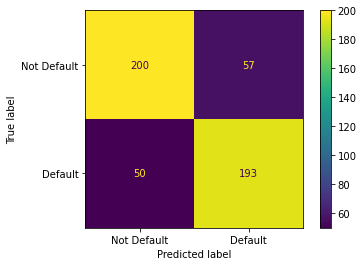

In [33]:
## Check Testing Data and Draw Confusion Matrix
plot_confusion_matrix(clf_svm,X_test_scaled,y_test, 
                     values_format='d',
                     display_labels=["Not Default","Default"])
## 0.78

In [34]:
param_grid = [
    {'C': [0.5,1, 10, 100], # Note: values for C must > 0
    'gamma': ['scale',1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

## NOTE: we are including C=1 and gamma= 'scale' as possible choices 
## since they are default values

optimal_params = GridSearchCV(
    SVC(),
    param_grid, cv=5,
    scoring='accuracy',
    verbose=0 # if you want to see hat grid search is doing, set to 2
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [35]:
clf_svm = SVC(random_state=42, C=100,gamma=0.0001)
clf_svm.fit(X_train_scaled,y_train)

SVC(C=100, gamma=0.0001, random_state=42)

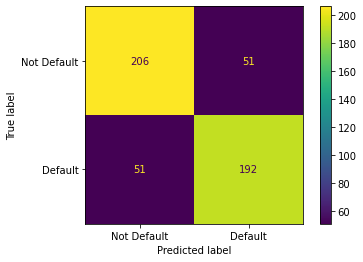

In [36]:
plot_confusion_matrix(clf_svm,X_test_scaled,y_test, 
                     values_format='d',
                     display_labels=["Not Default","Default"])

In [37]:
len(df_sample.columns) ## 24

21

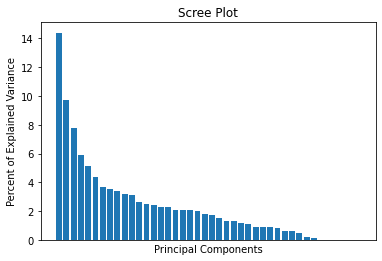

In [38]:
pca = PCA() # NOTE: by default, PCA centers the data, but not scale it. 
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1,len(per_var) + 1)]

plt.bar(x=range(1,len(per_var) + 1), height=per_var)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Percent of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [40]:
train_pc1_coords = X_train_pca[:,0]
train_pc2_coords = X_train_pca[:,1]

## NOTE: 
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## NOW center and scale the PCs
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## Now we optimze the SVM fit to the x and y-axis coordinates
## of the data after PCA dimension reduction..
param_grid2 = [
    {'C': [1,10,100,1000],
     'gamma':['scale',1,0.1,0.01,0.001,0.0001],
     'kernel':['rbf']
    },
]

optimal_params2 = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


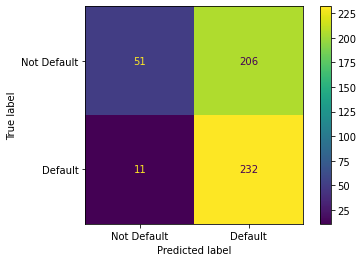

In [41]:
clf_svm = SVC(random_state=42, C=10,gamma=1)
clf_svm.fit(X_train_scaled,y_train)

## Check Testing Data and Draw Confusion Matrix
plot_confusion_matrix(clf_svm,X_test_scaled,y_test, 
                     values_format='d',
                     display_labels=["Not Default","Default"])